# 4. Diffuser实战
训练扩散模型的流程
1. 从训练集中加载图像
2. 添加不同级别的噪声
3. 将添加了不同级别噪声的数据输入模型
4. 评估模型对这些输入去噪的效果
5. 使用得到的性能信息更新模型权重，然后重复上述步骤

## Step 1: Setup

In [ ]:
# %pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

In [ ]:
from huggingface_hub import notebook_login

"""
可使用命令行：huggingface-cli login登陆

token: *************
"""

# notebook_login()

In [ ]:
# %%capture
# !sudo apt -qq install git-lfs
# !git config --global credential.helper store

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from diffusers import StableDiffusionPipeline

"""
从hugging face hub上下载模型权重等需要的文件
"""

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline（加载管线）
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

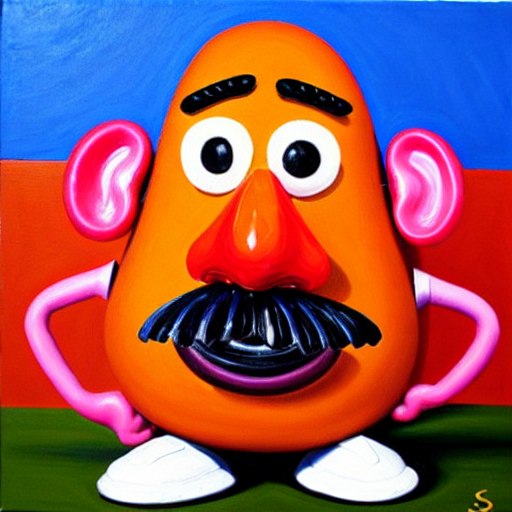

In [3]:
"""
生成示例图像
- num_inference_steps：采样步骤的数量
- guidance_scale：模型的输出与提示语之间的匹配程度
"""
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

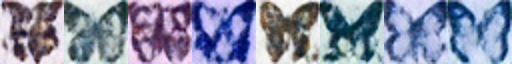

In [4]:
"""
创建属于自己的pipeline，用于生成蝴蝶图片
"""

from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)



## Step 2: Download a training dataset

In [71]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

# dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset('imagefolder',data_dir="/home/zhangzq/Downloads/smithsonian_butterflies_subset/data",split='train')
dataset = load_dataset(path='/home/zhangzq/Downloads/smithsonian_butterflies_subset',data_dir="data",split='train')
# dataset=load_dataset("/home/zhangzq/Downloads/smithsonian_butterflies_subset/data",split='train')

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # 转为张量的同时Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               shuffle=True)
# train_dataloader

Repo card metadata block was not found. Setting CardData to empty.


X shape: torch.Size([8, 3, 32, 32])


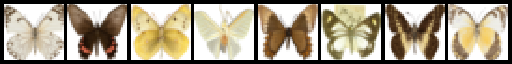

In [74]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize([8 * 64, 64], resample=Image.Resampling.NEAREST)

### 扩散模型之调度器
- 在训练阶段，指定添加噪声的scheduler，将加噪后的图片送入模型
- 在推理阶段，使用模型预测的结果逐步消除噪声

In [75]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.19.3",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [76]:
dir(noise_scheduler)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compatibles',
 '_deprecated_kwargs',
 '_dict_from_json_file',
 '_get_compatibles',
 '_get_init_keys',
 '_get_variance',
 '_internal_dict',
 '_threshold_sample',
 'add_noise',
 'alphas',
 'alphas_cumprod',
 'betas',
 'compatibles',
 'config',
 'config_name',
 'custom_timesteps',
 'extract_init_dict',
 'from_config',
 'from_pretrained',
 'get_config_dict',
 'get_velocity',
 'has_compatibles',
 'ignore_for_config',
 'init_noise_sigma',
 'load_config',
 'num_inference_steps',
 'one',
 'order',
 'previous_timestep',
 'register_to_config',
 'save_config',
 'save_pretrained',
 'scale_model_input',
 

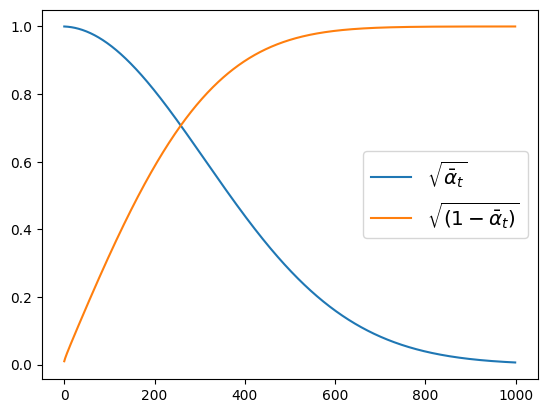

In [60]:
"""
在DDPMScheduler下，两个参数的变化情况
"""

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

In [ ]:
"""
可调整beta_start、beta_end、beta_schedule三个参数来控制噪声调度器的超参数beta
"""

# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

Noisy X shape torch.Size([8, 3, 32, 32])


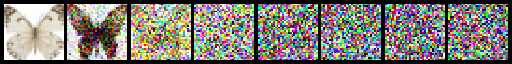

In [78]:
"""
可通过noise_scheduler.add_noise为数据添加噪声
"""

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize([8 * 64, 64], resample=Image.Resampling.NEAREST)

### 定义扩散模型
![](./imgs/4_1.png)

In [79]:
from diffusers import UNet2DModel

"""
注意力模块
- 能够帮助神经网络定位特征图中最重要的部分
- 在分辨率最低的网络深处使用
"""

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters

    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),

    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [80]:
"""
检查输出尺寸
"""
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

### 创建扩散模型训练循环
每一个batch的训练流程：
1. 随机采样几个迭代周期
2. 对数据进行相应的噪声处理
3. 把“带噪”数据输入模型
4. 将MSE作为损失函数
5. 调用loss.backward()和optimizer.step()来更新模型参数

In [82]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# 定义优化器用于参数更新
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        batch_size = clean_images.shape[0]

        # Sample a random timestep for each image（为每张图片随机采样一个时间步）
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (batch_size,), device=clean_images.device
        ).long()

        # print('timesteps:',timesteps,' timesteps.shape:',timesteps.shape)  # timesteps.shape:torch.Size([64])

        # Add noise to the clean images according to the noise magnitude at each timestep
        # 根据每个时间步的噪声幅度，向清晰的图片中添加噪声
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

/home/zhangzq/anaconda3/envs/py3.8/lib/python3.8/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.08210674626752734
Epoch:10, loss: 0.07531516789458692
Epoch:15, loss: 0.06566321500577033
Epoch:20, loss: 0.06572935706935823
Epoch:25, loss: 0.0618520260322839
Epoch:30, loss: 0.06013149139471352


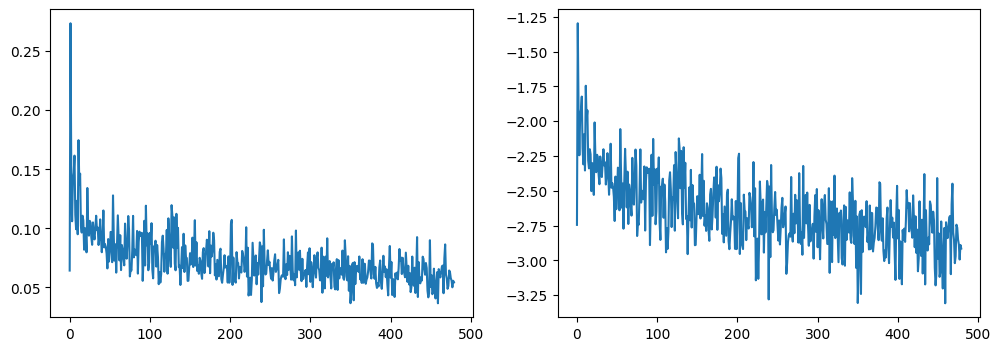

In [83]:
"""
画出损失曲线
"""
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [ ]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

## Step 6: Generate Images

### Option 1: Creating a pipeline:

In [3]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

NameError: name 'model' is not defined

  0%|          | 0/1000 [00:00<?, ?it/s]

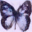

In [87]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [88]:
image_pipe.save_pretrained("./4_1_my_pipeline")

In [89]:
"""
- unet/diffusion_pytorch_model.bin:模型参数文件
- unet
"""

!ls 4_1_my_pipeline/

model_index.json  scheduler  unet


In [90]:
!ls 4_1_my_pipeline/unet/

config.json  diffusion_pytorch_model.bin


### Option 2: Writing a Sampling Loop

In [2]:
"""
查看管线（pipeline）中的forward方法
"""
??image_pipe.forward

Object `image_pipe.forward` not found.


We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:

In [ ]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):  # 从最大噪声往最小噪声方向运行调度器

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample  # 获得模型的预测结果

    # Update sample with step
    # 根据预测结果更新图像
    # noise_scheduler.step()方法：对应不同的采样方法
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

## Step 7: Push your model to the Hub

hugging face hug根据用户的选择（模型ID）来决定模型存储库的名称（用户可自由更改model_name，其只需包含用户名即可）

In [4]:
"""
get_full_repo_name()：由model_name生成hub_model_id
"""

from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [ ]:
"""
在hugging face hub上创建模型仓库并将其上传

"""

from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

In [ ]:
"""

通过以下代码创建一个精美的模型卡片

"""

from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

## 使用Accelerate库扩大训练模型的规模

In [ ]:
"""
在大量数据上训练较大模型的示例代码
- 多GPU支持
- 进度记录与示例图像
- 支持较大批量的梯度检查点
- 自动上传模型
"""

!wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

In [ ]:
"""
获取模型
"""
# Let's give our new model a name for the Hub
model_name = "sd-class-butterflies-64"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

In [ ]:
"""

执行下面代码即可通过Accelerate库启动训练脚本，该库可自动完成诸如多GPU并行训练的训练部署功能

"""

!accelerate launch train_unconditional.py \
  --dataset_name="huggan/smithsonian_butterflies_subset" \
  --resolution=64 \
  --output_dir={model_name} \
  --train_batch_size=32 \
  --num_epochs=50 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=500 \
  --mixed_precision="no"

In [ ]:
"""
将模型push到Hugging face hub并创建一个模型卡片
"""

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

In [ ]:
"""
使用训练好的模型采样生成数据
"""

pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=8).images
make_grid(images)